# SUMMER MIDNIGHT ML SLAM #1👯‍♀️
Pushing Old concepts to the limits!<br>
Today's guest: **LSTMs**!

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

### Challenge 1. Image Captioning!
This one I haven't tried before, so it's pretty interesting to try out!<br>
For CNN encoder we'll use pretrained ResNet (cuz this is LSTMs devoted slam)<br>
Oh shoot... I forgot how to load image datasets and use datasets/dataloader in general...

In [27]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

In [26]:
df = pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")

image_paths = df["image"].values
captions = df["caption"].values

In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [31]:
class CaptioningDataset(Dataset):
    def __init__(self, root_dir, img_paths, captions, transform=None):
        self.root_dir = root_dir
        self.img_paths = img_paths
        self.captions = captions
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, i):
        img_path = os.path.join(self.root_dir, self.img_paths[i])
        img = Image.open(img_path).convert("RGB")
        caption = self.captions[i]
        if self.transform:
            img = self.transform(img)
            
        return img, caption

In [33]:
dataset = CaptioningDataset(
    root_dir="/kaggle/input/flickr8kimagescaptions/flickr8k/images",
    img_paths=image_paths,
    captions=captions,
    transform=transform
)

In [34]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

A brown dog is laying in the snow .


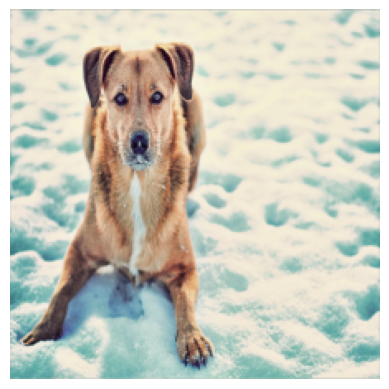

In [59]:
imgs, caps = next(iter(dataloader))

plt.axis("off")
print(caps[0])
plt.imshow(imgs[0].permute(1, 2, 0));

In [96]:
from collections import Counter

all_words = []
for caption in captions:
    all_words.extend(caption.lower().split())

word_counts = Counter(all_words)

min_freq = 10
vocab = {word for word, count in word_counts.items() if count >= min_freq}
vocab.add("<UNK>")
vocab.add("<SOS>")
vocab.add("<EOS>")


word2idx = {word: idx for idx, word in enumerate(sorted(vocab))}
n_words = len(word2idx)

unk_captions = []
for caption in captions:
    words = caption.lower().split()
    unk_caption = [word if word in vocab else "<UNK>" for word in words]
    unk_captions.append("<sos>" + " ".join(unk_caption) + "<eos>")

captions = np.array(unk_captions)

In [97]:
dataset = CaptioningDataset(
    root_dir="/kaggle/input/flickr8kimagescaptions/flickr8k/images",
    img_paths=image_paths,
    captions=captions,
    transform=transform
)

In [98]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

<sos>a hockey <unk> lays on the ice and other players skate past him .<eos>


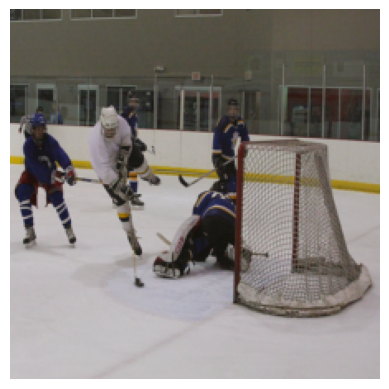

In [99]:
imgs, caps = next(iter(dataloader))

plt.axis("off")
print(caps[0])
plt.imshow(imgs[0].permute(1, 2, 0));

In [100]:
n_words

707

In [101]:
class CaptioningLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, output_size):
        super().__init__()
        self.input_size = embed_size  # Embeddings used
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.inp_emb = nn.Embedding(output_size, embed_size)
        # Reset Gate
        self.ft = nn.Linear(embed_size + hidden_size, hidden_size)
        self.ft_gate = nn.Sigmoid()
        # Candidate Gate
        self.it = nn.Linear(embed_size + hidden_size, hidden_size)
        self.it_gate = nn.Sigmoid()
        self.c_t = nn.Linear(embed_size + hidden_size, hidden_size)
        self.c_t_act = nn.Tanh()
        # Update Gate
        self.ot = nn.Linear(embed_size + hidden_size, hidden_size)
        self.ot_gate = nn.Sigmoid()
        self.ct_act = nn.Tanh()
        self.out = nn.Linear(embed_size, output_size)

    def forward(self, input_, cell, hidden):
        input_ = self.inp_emb(input_)
        inp_hid = torch.cat([input_, hidden], dim=1)
        ft = self.ft_gate(self.ft(inp_hid))
        it = self.it_gate(self.it(inp_hid))
        c_t = self.c_t_act(self.c_t(inp_hid))
        # Cell Update
        cell = cell * ft + (it * c_t)
        ot = self.ot_gate(self.ot(inp_hid))
        ht = self.ct_act(cell) * ot
        out = self.out(ht)

In [102]:
from torchvision.models import resnet50

Now the hardest thing... Put it all together

In [109]:
resnet50_pretrained = resnet50(weights='DEFAULT')
resnet_encoder = nn.Sequential(*list(resnet50_pretrained.children())[:-1])

for layer in resnet_encoder.children():
    layer.requires_grad = False

In [111]:
from torchsummary import summary
summary(resnet_encoder, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
EPOCHS = 50
emb_size = 48
hidden_size = 2048
output_size = n_words

lstm = CaptioningLSTM(emb_size, hidden_size, output_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.)

for epoch in range(EPOCHS):
    for imgs, caps in dataloader:
        # OKAY, IMPLEMENT IT TOMORROW